### Import packages

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Box, Discrete
import random
from IPython.display import clear_output
import pickle

### Create environment

In [2]:
class BertrandEnv():
    
    def __init__(self):
        self.action_space = Discrete(3) # 3 choices
        self.observation_space = Discrete(9) # 9 states
        self.state = 8 # might as well be 5 for example
        self.periods = 20 # periods starts at 20 (will be reduced by one after every step)
        
    def step(self, action1, action2): #action1 = own price setting, action2 = competitor price setting
              
        #adjusting state based on action manually
        if action1 == 0 and action2 == 0:
            self.state = 0 # codes for states from 0 to 8
        elif action1 == 0 and action2 == 1:
            self.state = 1
        elif action1 == 0 and action2 == 2:
            self.state = 2
        elif action1 == 1 and action2 == 0:
            self.state = 3
        elif action1 == 1 and action2 == 1:
            self.state = 4
        elif action1 == 1 and action2 == 2:
            self.state = 5
        elif action1 == 2 and action2 == 0:
            self.state = 6
        elif action1 == 2 and action2 == 1:
            self.state = 7
        elif action1 == 2 and action2 == 2:
            self.state = 8        
        
        #discount 1 period
        self.periods -= 1 # reduce periods by 1 for every step
        
        #defining price for each action, to calculate rewards in every round
        if action1 == 0:
            set_price = 6
        elif action1 == 1:
            set_price = 7
        elif action1 == 2:
            set_price = 8
            
        if action2 == 0:
            comp_price = 6
        elif action2 == 1:
            comp_price = 7
        elif action2 == 2:
            comp_price = 8
        
        # Calculating the rewards
        # differentiated bertrand model w/ inverse demand curves: q1 = 15 - 2p1 + 1.5p2 and q2 = 15 - 2p2 + 1.5p1
        
        reward1 = set_price*(15 - (2*set_price) + (1.5*comp_price)) # p1 * q1
        reward2 = comp_price*(15 - (2*comp_price) + (1.5*set_price)) # demand curve for both players is the same
        
        # Checking if periods are over
        if self.periods <= 0: # if period has been reduced 20 times, done = true
            done = True
        else:
            done = False
        
        
        # Returning the step information
        return self.state, reward1, reward2, done
    
    def reset(self): # similar to __init__
        self.state = 2 #could also be 0 for example
        self.periods = 20 # restart for another 20 periods
        return self.state

In [3]:
env = BertrandEnv()

In [4]:
#test environment

profit1 = 0
profit2 = 0

episodes = 10 #10 times of setting price 20 times
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
 
    while not done:
        action1 = env.action_space.sample()
        action2 = env.action_space.sample()
        n_state, reward1, reward2, done = env.step(action1, action2)
        profit1 += reward1
        profit2 += reward2
    print('Episode:{} Profit:{} Profit competitor:{}'.format(episode, profit1, profit2)) #shows total profit of 1 episode

Episode:1 Profit:1574.5 Profit competitor:1608.5
Episode:2 Profit:3213.0 Profit competitor:3161.0
Episode:3 Profit:4785.0 Profit competitor:4804.0
Episode:4 Profit:6405.5 Profit competitor:6360.5
Episode:5 Profit:7987.0 Profit competitor:7916.0
Episode:6 Profit:9600.0 Profit competitor:9514.0
Episode:7 Profit:11135.0 Profit competitor:11075.0
Episode:8 Profit:12680.5 Profit competitor:12639.5
Episode:9 Profit:14189.5 Profit competitor:14259.5
Episode:10 Profit:15712.5 Profit competitor:15805.5


### Q-learning algorithm

In [5]:
# parameters
alpha = 0.1 # learning rate, 0.1 usually used in computer science (Calvano, 2020)

gamma = 0.9 # between 0.8 and 0.99
    #if 0, values in final q-table should be in range of payoff matrix
    #if 1, evaluates total profit
    # should be high, because we look at long term
    
beta = 0.002 # parameter for diminishing epsilon rate
    
epsilon1 = 0.99 # initial exploration - exploitation rate
epsilon2 = 0.99

# create placeholder for cumulative rewards
profit1 = 0
profit2 = 0

#initialize Q-tables
q_table1 = np.zeros([env.observation_space.n, env.action_space.n])
q_table2 = np.zeros([env.observation_space.n, env.action_space.n]) # caution: transposed q-table

In [6]:
# check epsilon rate after 10 000 episodes
epsilon1**(beta*100000)

0.13397967485796172

In [7]:
#set amount of training episodes
num_of_episodes = 500000
    
# placeholder to append total episode reward
episode_rewards1 = []
episode_rewards2 = []

#for loop on environment
for episode in range(0, num_of_episodes):
    
    # Reset the enviroment
    state = env.reset()
    
    # reset episode reward to 0
    ep_reward1 = 0
    ep_reward2 = 0

    # Initialize variables
    done = False
    
    while not done:
        
        # epsilon based policy: exploring or choosing max from state
        if random.uniform(0, 1) < epsilon1**(beta*episode): # epsilon decreased based on number of episode
            action1 = env.action_space.sample()
        else:
            action1 = np.argmax(q_table1[state]) # state or n_state???
            
        #same for player 2
        if random.uniform(0, 1) < epsilon2**(beta*episode):
            action2 = env.action_space.sample()
        else:
            action2 = np.argmax(q_table2[state])

        # take action and transition to next state
        n_state, reward1, reward2, done = env.step(action1, action2) #step function needs input of both 1 and 2
        
        # add reward to cumulative reward (=profit)
        profit1 += reward1
        profit2 += reward2
        
        # add reward to episode reward
        ep_reward1 += reward1
        ep_reward2 += reward2
        
        # recalculate
        q_value1 = q_table1[state, action1]
        max_value1 = np.max(q_table1[n_state])
        new_q_value1 = (1 - alpha) * q_value1 + alpha * (reward1 + gamma * max_value1) # theory
        
        q_value2 = q_table2[state, action2]
        max_value2 = np.max(q_table2[n_state])
        new_q_value2 = (1 - alpha) * q_value2 + alpha * (reward2 + gamma * max_value2)
        
        # update rule for Q-table
        q_table1[state, action1] = new_q_value1
        q_table2[state, action2] = new_q_value2
        state = n_state
        
    # append reward of episode to list of episode rewards
    episode_rewards1.append(ep_reward1)
    episode_rewards2.append(ep_reward2)
    
    # printing output every 100 episodes
    if (episode + 1) % 100 == 0: # = at every 100 episodes
        clear_output(wait=True)
        print("Episode: {}".format(episode + 1))


print("Training is done!\n")

Episode: 500000
Training is done!



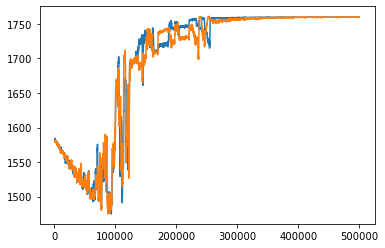

In [8]:
# use episode rewards to check evolution over episodes
plt.plot(pd.Series(episode_rewards1).rolling(1000).mean())
plt.plot(pd.Series(episode_rewards2).rolling(1000).mean());

In [9]:
# set states for both q-tables up for comparison
q_table2_eq = q_table2
q_table2_eq[[0,1,2,3,4,5,6,7,8]] = q_table2[[0,3,6,1,4,7,2,5,8]] # states in first q-table are set up in 000111222 actions
                                                                    # and in second q-table are set up in 012012012 actions
# compare values both q-tables
diff_q = q_table2_eq - q_table1
print(diff_q)

# check best response to each state
print(np.argmax(q_table1, axis=1))
print(np.argmax(q_table2_eq, axis=1))

# check latest state
print(state)

[[ 39.20406005 -11.1460773  -62.09730044]
 [-19.62705489 -16.59200857  -8.69966633]
 [-35.70014358 -29.41833641 -25.62697415]
 [-27.06010807 -18.70243418  18.41172679]
 [ 31.8714823  -38.64516871 -39.59898251]
 [ 16.78807117 -12.16704741  -3.43878396]
 [-26.70192501  13.93813457  35.49066656]
 [-24.0000685   12.57568641   3.0251555 ]
 [-21.01903526  -9.21075452   0.        ]]
[2 0 2 2 2 2 0 0 2]
[0 0 2 2 0 2 2 0 2]
8


In [10]:
# save final q-table1 for experiment
np.save('final_q_table', q_table1)